# 加载常用的库文件

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from dotenv import load_dotenv

load_dotenv()
output_folder_path='./output/city_unet1/'
os.makedirs(output_folder_path ,exist_ok=True)

Python-dotenv could not parse statement starting at line 17
Python-dotenv could not parse statement starting at line 20
Python-dotenv could not parse statement starting at line 22
Python-dotenv could not parse statement starting at line 24
Python-dotenv could not parse statement starting at line 26


### 获取数据集

In [2]:
DATASET = os.getenv('CITY_SCAPES_DATASET')
folder_path= DATASET
TrainFolder = os.path.join(folder_path+'train/*')
TestFolder = os.path.join(folder_path+'val/*')
train_path = glob(TrainFolder)
valid_path = glob(TestFolder)

### 数据集可视化

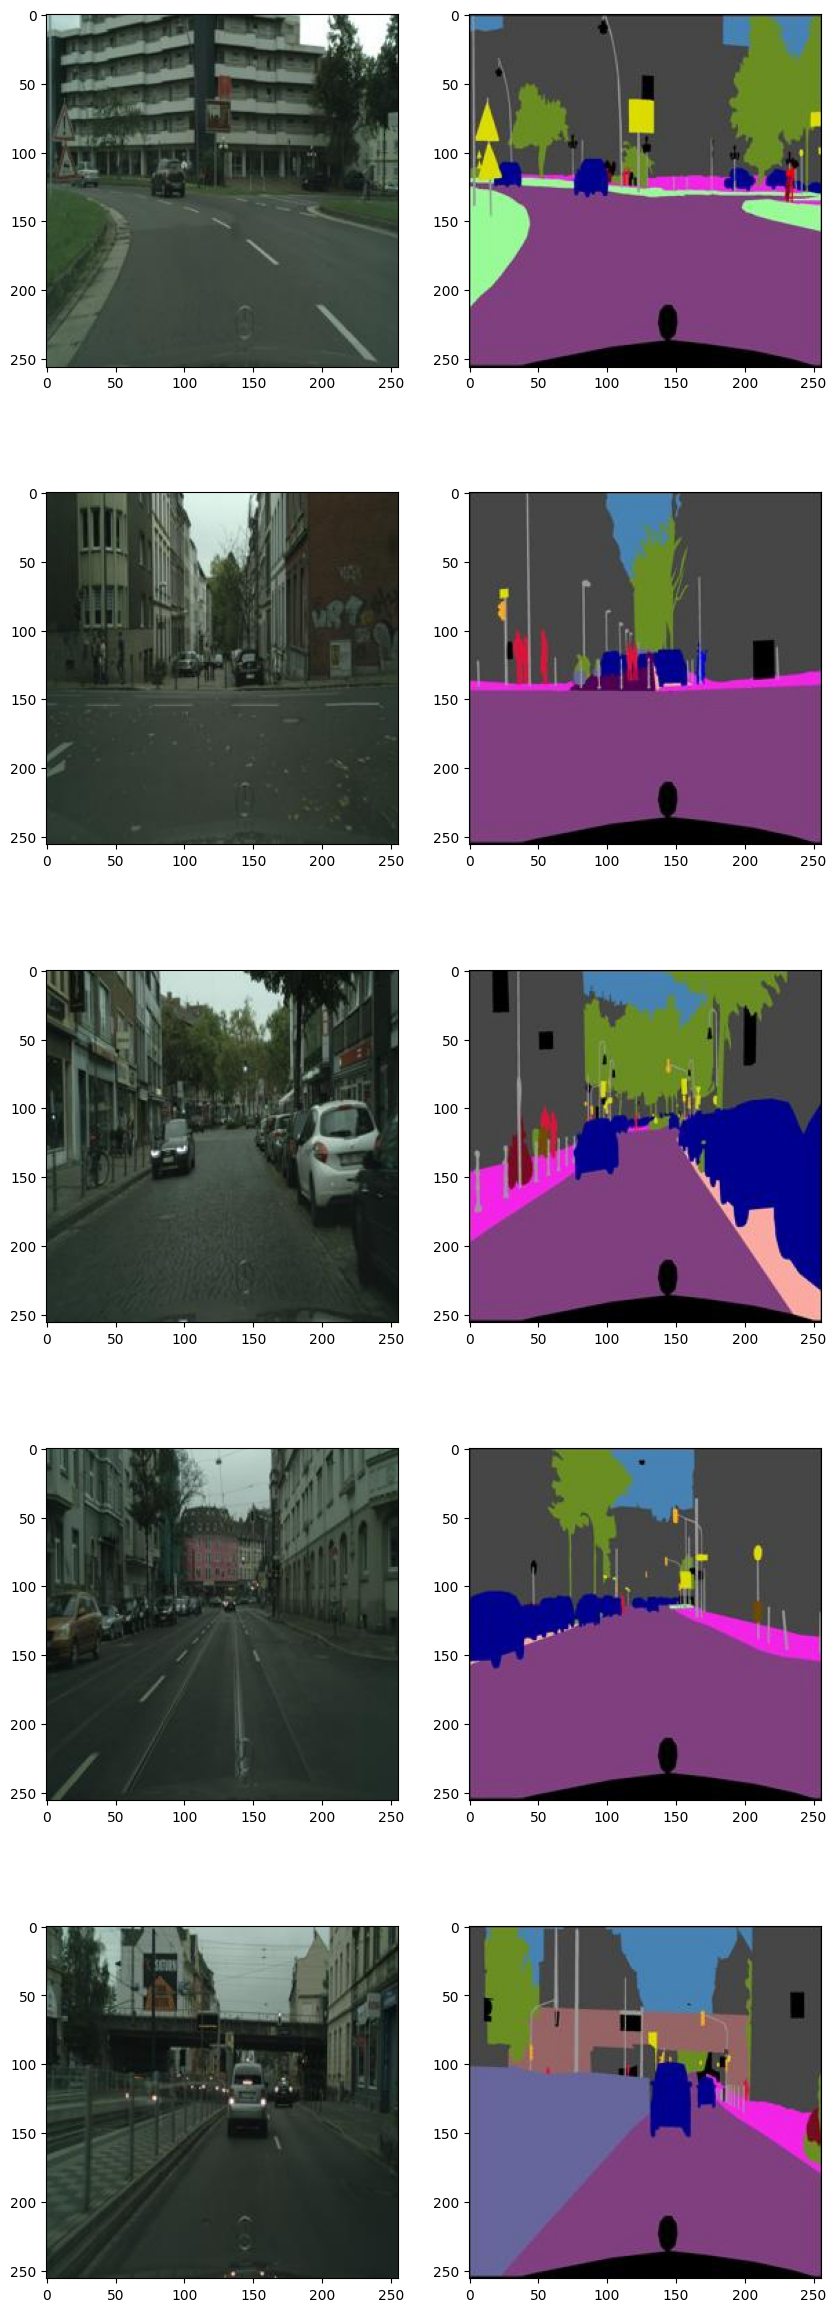

In [3]:
fig,ax = plt.subplots(5,2,figsize=(10,30))
for i in range(5):
    img = plt.imread(train_path[i])
    ax[i][0].imshow(img[:,:256])
    ax[i][1].imshow(img[:,256:])

### 定义数据集

In [4]:
train_dataset = []
validation_dataset = []

In [5]:
class MyDataset(Dataset):
    
    def __init__(self, images_path ,transform_img=None ,transform_label=None):
        
        self.images_path = images_path
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        
        img = plt.imread(self.images_path[idx])
        image,label = img[:,:int(img.shape[1]/2)],img[:,int(img.shape[1]/2):]
    
        if self.transform_img:
            image = self.transform_img(image)
            
        if self.transform_label:
            label = self.transform_label(label)
            
        return image, label

### 定义数据变换

In [6]:
mytransformsImage = transform.Compose(
    [
        transform.ToTensor(),
        #transform.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        transform.RandomHorizontalFlip(p=0.9)
    ]
)

mytransformsLabel = transform.Compose(
    [
        transform.ToTensor(),
    ]
)

In [7]:
# train dataset
traindata = MyDataset(train_path, mytransformsImage, mytransformsLabel)
# val dataset
valdata = MyDataset(valid_path, mytransformsImage, mytransformsLabel)
print(len(traindata))
print(valid_path)

2975
['D:\\\\DATASET\\\\cityscapes\\\\val\\1.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\10.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\100.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\101.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\102.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\103.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\104.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\105.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\106.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\107.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\108.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\109.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\11.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\110.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\111.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\112.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\113.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\114.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\115.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\116.jpg', 'D:\\\\DATASET\\\\cityscapes\\\\val\\117.jpg', 'D:\\\\DATA

In [8]:
# Creating the DataLoaders
batch_size = 4
train_loader = DataLoader(traindata,batch_size)
valid_loader = DataLoader(valdata,1)

In [9]:

def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(10,10))
    
    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][1].imshow(Lab)
            ax[i][2].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[1].imshow(Lab)
            ax[2].imshow(act.permute(1,2,0))
    plt.show()

In [10]:
device = 'cpu'

# 构建UNet模型


<br>

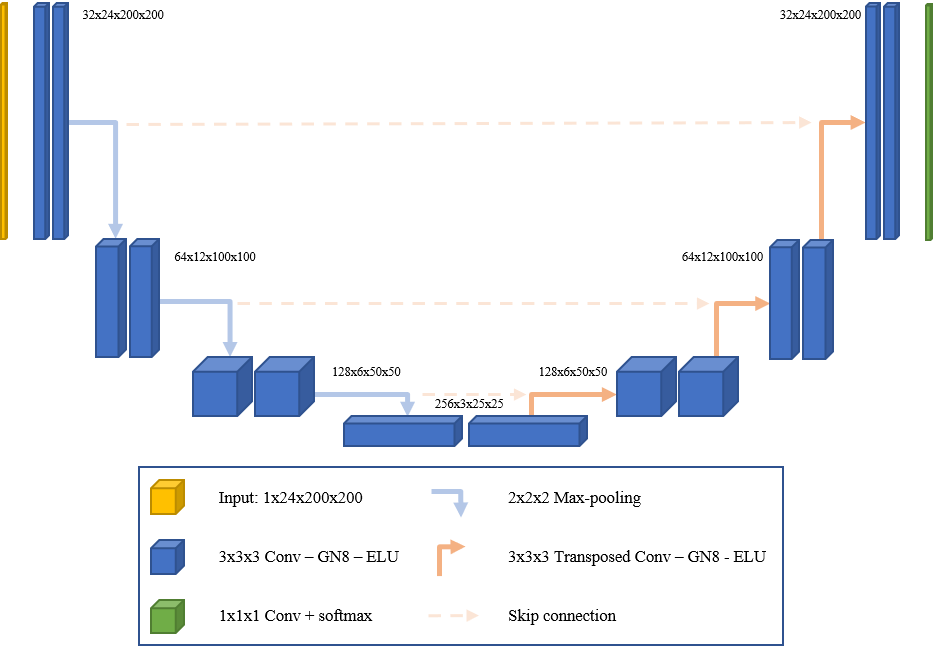

In [11]:
'''

    This Module representes the individual horizontal conv block layers in the Unet Model.
    Conv() -> BatchNorm() -> ReLU() -> Conv() -> ReLU()

'''

class Convblock(nn.Module):
    
      def __init__(self,input_channel,output_channel,kernal=3,stride=1,padding=1):
            
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel,output_channel,kernal,stride,padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel,output_channel,kernal),
            nn.ReLU(inplace=True),
        )
    

      def forward(self,x):
        x = self.convblock(x)
        return x

In [12]:
# Encoder -> BottelNeck => Decoder
class UNet(nn.Module):
    
    def __init__(self,input_channel,retain=True):

        super().__init__()

        self.conv1 = Convblock(input_channel,32)
        self.conv2 = Convblock(32,64)
        self.conv3 = Convblock(64,128)
        self.conv4 = Convblock(128,256)
        self.neck = nn.Conv2d(256,512,3,1)
        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(512,256)
        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(256,128)
        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(128,64)
        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(64,32)
        self.out = nn.Conv2d(32,3,1,1)
        self.retain = retain
        
    def forward(self,x):
        
        # Encoder Network
        
        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1,kernel_size=2,stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2,kernel_size=2,stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3,kernel_size=2,stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4,kernel_size=2,stride=2)

        # BottelNeck
        neck = self.neck(pool4)
        
        # Decoder Network
        
        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4,croped],1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3,croped],1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2,croped],1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1,croped],1))
        # Output Layer
        out = self.out(dconv1)
        
        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])

        return out
    
    def crop(self,input_tensor,target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _,_,H,W = target_tensor.shape
        return transform.CenterCrop([H,W])(input_tensor)

### 创建训练循环

In [13]:
MODELS_FOLDER = os.getenv('MODEL_FOLDER_PATH')
model_folder_path= MODELS_FOLDER
OUR_UNET1_MODEL_File = os.path.join(model_folder_path+'our_unet1_model.pth')
LOAD_MODEL_FILE = OUR_UNET1_MODEL_File
LOAD_FILE= True
    
def save_checkpoint(checkpoint, filename):
    torch.save(checkpoint, filename)

# Define training parameters 
LEARNING_RATE = 0.01
EPOCHS = 30

# initializing the model
model = UNet(3).float().to(device)

# Initialize loss function
criterion = nn.MSELoss()

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

if LOAD_FILE:
    # Load the checkpoint
    checkpoint_path = LOAD_MODEL_FILE
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print(LOAD_MODEL_FILE)
    
LOAD_FILE= True

D:\\MODELS\\our_unet1_model.pth


In [ ]:

    
#MODEL TRAINING AND SAVING PART START   

# Lists to store losses
train_acc = []
val_acc = []
train_loss = []
val_loss = []

# Training loop
for i in range(EPOCHS):
    
    trainloss = 0
    valloss = 0
    
    for img,label in tqdm(train_loader):
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()
    
    if(i%5==0):
        show(img,output,label)

    train_loss.append(trainloss/len(train_loader))    
  
    for img,label in tqdm(valid_loader):
        '''
            Validation of Model.
        '''
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = criterion(output,label)
        valloss+=loss.item()
        
    val_loss.append(valloss/len(valid_loader))  
    
    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))
# Save the model checkpoint
checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}
save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)

#MODEL TRAINING AND SAVING PART FINISH


# 画训练和验证loss的曲线

In [ ]:
#MODEL TRAINING PLOT START

plt.plot(train_loss,color='b',label='train loss')
plt.plot(val_loss,color='r',label = 'val_loss')
plt.legend()
filename=f"{output_folder_path}train_loss_and_val_loss.png"
plt.savefig(filename)

#MODEL TRAINING PLOT FINISH

# 可视化结果

In [38]:
def show(img,output,label,denorm = False,output_image_name=None):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(15,30))
    cols = ['Input Image','Actual Output','Predicted Output']
    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][2].imshow(Lab)
            ax[i][1].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[2].imshow(Lab)
            ax[1].imshow(act.permute(1,2,0))
            #ax[0].title('this')
            for ax, col in zip(ax, cols):
                ax.set_title(col)
    if output_image_name:
        plt.savefig(f"{output_folder_path}outPutImage{output_image_name}")
        print('image downloaded')
    plt.show()

In [56]:
for img,label in tqdm(valid_loader):
    img = img.to(device)
    label = label.to(device)
    label = label.numpy().flatten()
    output = model(img)
    label = output.detach().numpy().flatten()
    print(output)
    print(label)
    break
    
    

  0%|          | 0/500 [00:00<?, ?it/s]

tensor([[[[1.3730e-01, 1.3730e-01, 1.6282e-01,  ..., 1.6056e-01,
           2.2544e-01, 1.1007e-01],
          [1.3730e-01, 1.3730e-01, 1.6282e-01,  ..., 1.6056e-01,
           2.2544e-01, 1.1007e-01],
          [1.6313e-01, 1.6313e-01, 3.3944e-01,  ..., 2.3205e-01,
           2.6028e-01, 8.7204e-02],
          ...,
          [9.9285e-02, 9.9285e-02, 4.1971e-02,  ..., 4.6336e-01,
           4.5262e-01, 1.5283e-01],
          [1.1669e-01, 1.1669e-01, 3.7768e-02,  ..., 3.3122e-01,
           3.5308e-01, 1.5355e-01],
          [1.4219e-01, 1.4219e-01, 5.0947e-02,  ..., 1.4310e-01,
           1.9215e-01, 1.4345e-01]],

         [[9.2093e-02, 9.2093e-02, 1.3255e-01,  ..., 1.0476e-01,
           1.3056e-01, 5.1658e-02],
          [9.2093e-02, 9.2093e-02, 1.3255e-01,  ..., 1.0476e-01,
           1.3056e-01, 5.1658e-02],
          [1.8566e-01, 1.8566e-01, 3.9781e-01,  ..., 2.4920e-01,
           2.2759e-01, 6.9984e-02],
          ...,
          [4.8304e-02, 4.8304e-02, 2.0252e-02,  ..., 2.7022

image downloaded


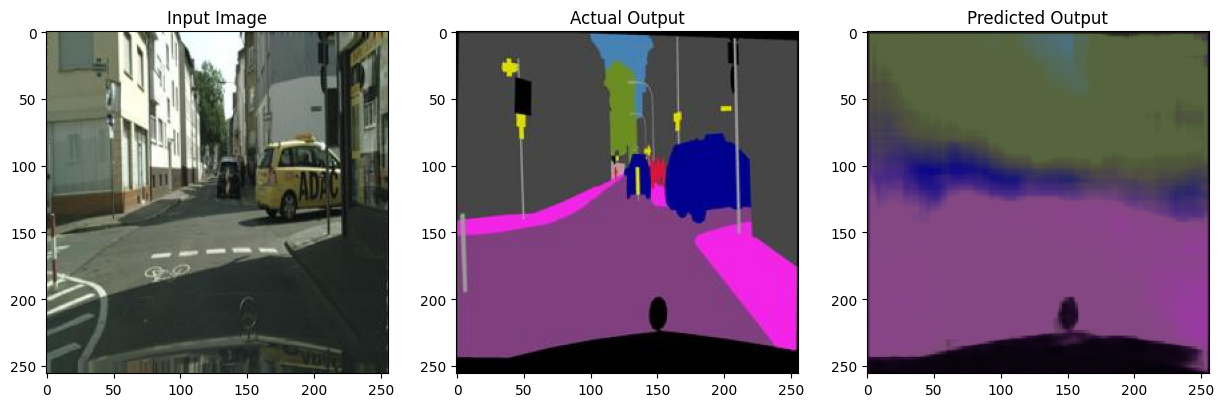

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image downloaded


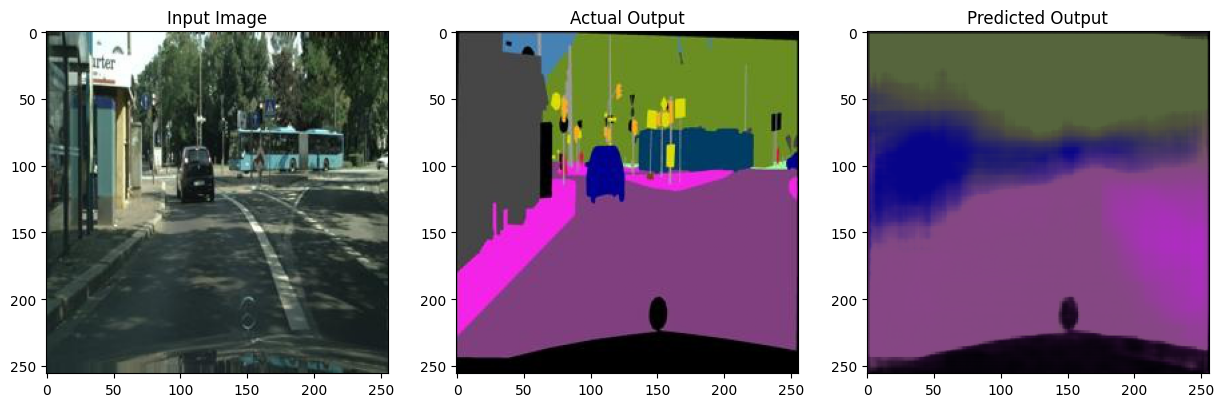

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image downloaded


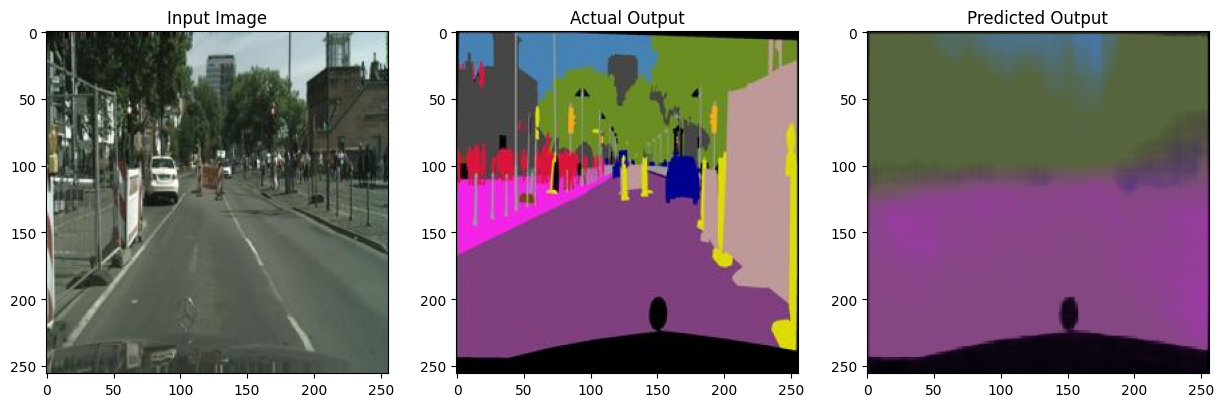

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image downloaded


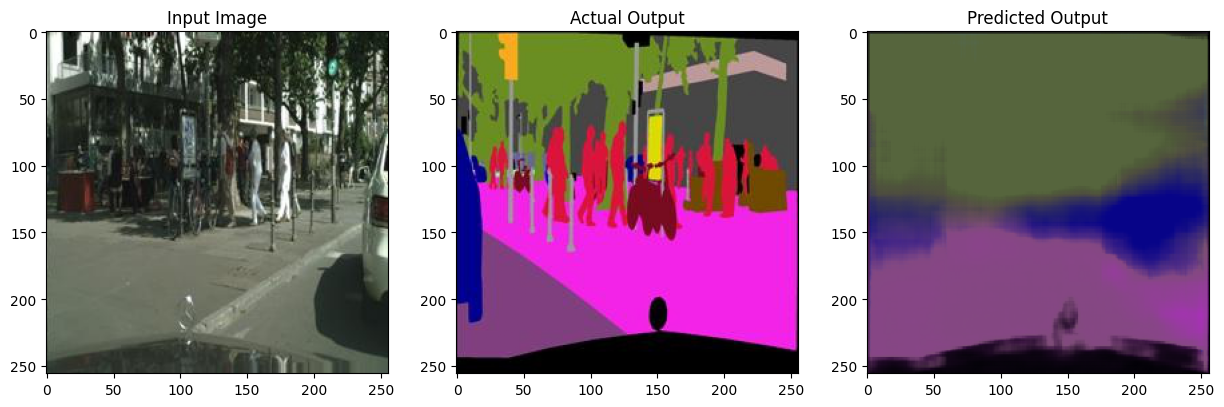

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image downloaded


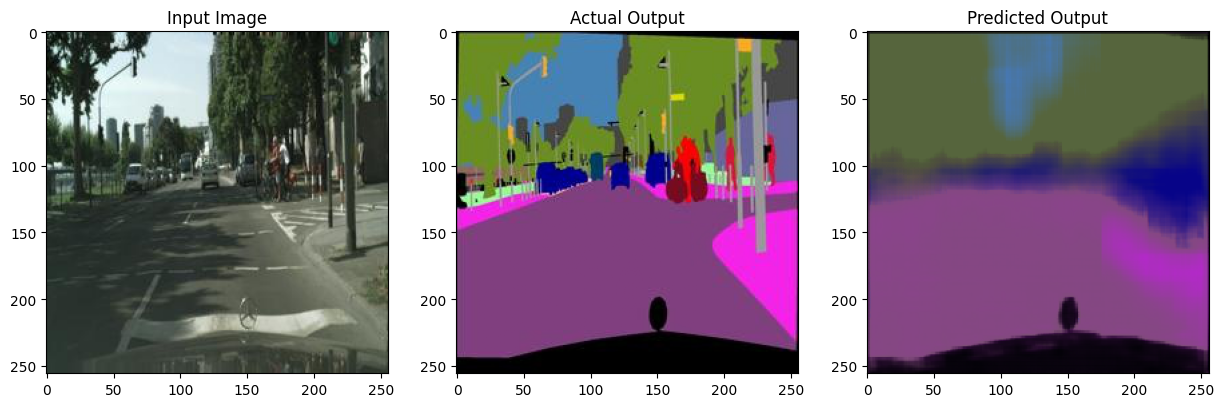

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image downloaded


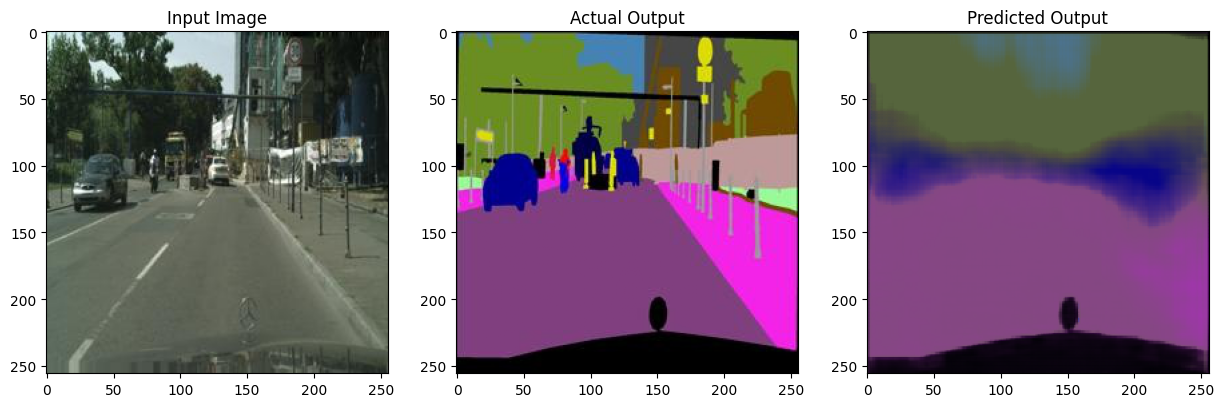

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image downloaded


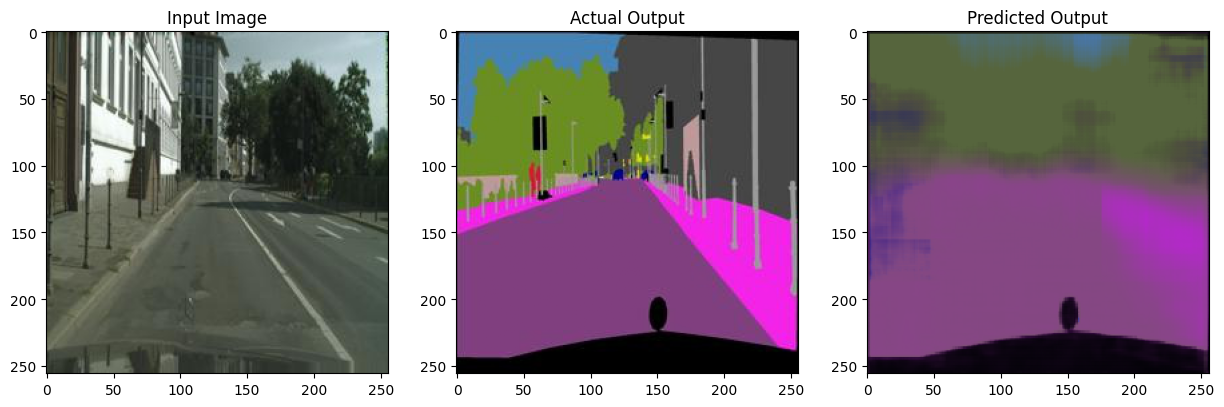

In [40]:
c = 0
for img,label in (valid_loader):
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        show(img,output,label,output_image_name=c+1)
        if c>5:
            break
        c+=1